In [17]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 7.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.7 MB/s eta 0:00:00a 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 8.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
data = pd.read_csv("ICU.csv", index_col = 0)
data

,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
1,4,0,87,3,1,1,80,96,1
2,8,1,27,1,1,1,142,88,1
3,12,1,59,2,0,0,112,80,1
4,14,1,77,3,0,0,100,70,0
5,27,0,76,3,1,1,128,90,1
...,...,...,...,...,...,...,...,...,...
196,921,0,50,2,1,0,256,64,1
197,923,1,20,1,0,0,104,83,1
198,924,1,73,3,1,0,162,100,1
199,925,1,59,2,0,0,100,88,1


Eventual goal is to predict a patient's survival rate, so 'Survival' feature will be our response.

Data inspection

In [11]:
max(data['Age']), min(data['Age'])

(92, 16)

In [12]:
data['AgeGroup'].value_counts()

2    77
3    64
1    59
Name: AgeGroup, dtype: int64

In [13]:
data['Sex'].value_counts()

0    124
1     76
Name: Sex, dtype: int64

In [14]:
data['Infection'].value_counts()

0    116
1     84
Name: Infection, dtype: int64

In [15]:
data['Emergency'].value_counts()

1    147
0     53
Name: Emergency, dtype: int64

In [16]:
data['Survive'].value_counts()

1    160
0     40
Name: Survive, dtype: int64

SysBP likely refers to Systolic Blood Pressure. From a quick Google search, I get the following groups which shall serve as bins for the plot for this feature  :

1. Healthy : < 120
2. Elevated : 120 - 129
3. Stage 1 Hypertension : 130 - 139
4. Stage 2 Hypertension : 140 - 179
5. Hypertension crisis : 180 or higher

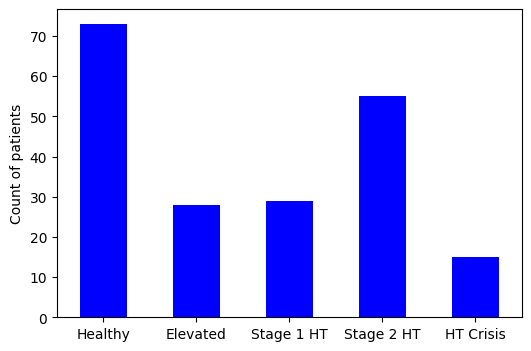

In [34]:
import matplotlib.pyplot as plt
#bins = [[0,119],[120, 129],[130, 139], [140, 179], [180, max(data['SysBP'])]]
out = pd.cut(data['SysBP'], bins=[0, 120, 130, 140, 180, max(data['SysBP'])], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels(['Healthy','Elevated','Stage 1 HT','Stage 2 HT','HT Crisis'])
plt.ylabel('Count of patients')
plt.show()